In [23]:
import numpy as np
from sklearn.model_selection import train_test_split
import os
import tifffile
import cv2
def get_max_value(dtype):
    if np.issubdtype(dtype, np.integer):
        return np.iinfo(dtype).max
    elif np.issubdtype(dtype, np.floating):
        return 1.0
    else:
        raise ValueError(f"Unsupported data type: {dtype}")

def load_tiff_images_and_masks(image_dir, mask_dir, image_size):
    images, masks = [], []
    i = 0
    for filename in os.listdir(image_dir):
        i += 1
        if filename.endswith('.tif') and i <= 150:
            image_path = os.path.join(image_dir, filename)
            mask_path = os.path.join(mask_dir, filename[:-4]+"_mask.tif")

            # Load and convert image
            image = tifffile.imread(image_path)/255.0
            # image = cv2.resize(image)
            mask = tifffile.imread(mask_path)[:,:,0]/255.0
            # mask = cv2.resize(mask)
            
            images.append(image)
            masks.append(mask)
        else:
            break

    return np.array(images), np.array(masks)

# Parameters
image_size = (1024, 1024)
image_dir = 'data/train/images'
mask_dir = 'data/train/masks'

# Load and prepare data
images, masks = load_tiff_images_and_masks(image_dir, mask_dir, image_size)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.1, random_state=42)
print(X_train.shape, X_train[0].shape)


(135, 1024, 1024, 3) (1024, 1024, 3)


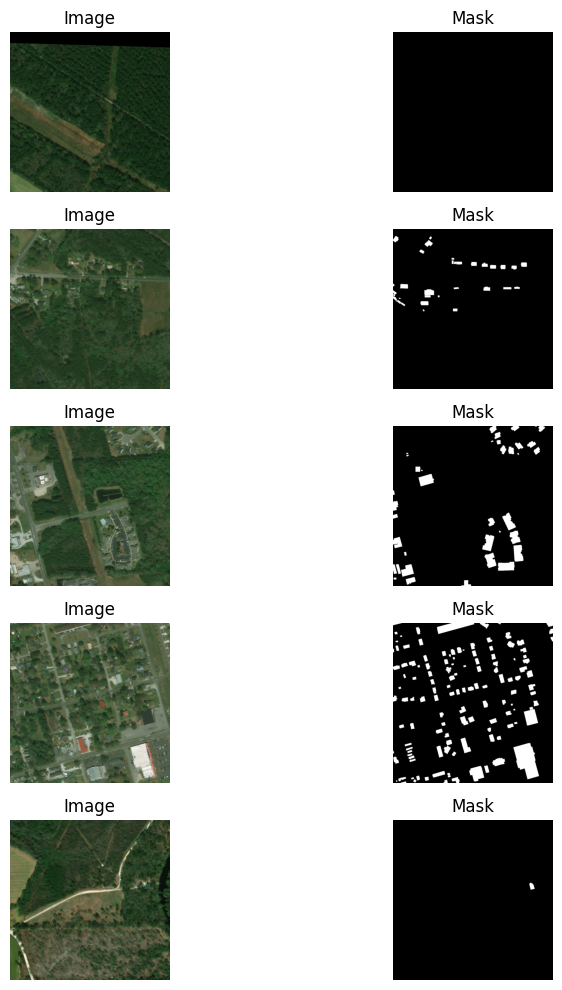

In [24]:
import matplotlib.pyplot as plt

def display_sample(images, masks, num_samples=5):
    plt.figure(figsize=(10, num_samples * 2))
    
    for i in range(num_samples):
        plt.subplot(num_samples, 2, 2*i + 1)
        plt.imshow(images[i])
        plt.title("Image")
        plt.axis("off")

        plt.subplot(num_samples, 2, 2*i + 2)
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.title("Mask")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

# Display sample images and masks
display_sample(X_train, y_train)


In [27]:
from keras.models import Model
from keras.layers import (Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, 
                                     Conv2DTranspose, concatenate)

def conv_block(input_tensor, num_filters):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters=num_filters, kernel_size=(3, 3), padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters=num_filters, kernel_size=(3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

def build_unet(input_shape):
    """Function to build a U-Net using the Keras functional API"""
    inputs = Input(input_shape)
    
    # Contracting Path
    c1 = conv_block(inputs, 32)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = conv_block(p1, 64)
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = conv_block(p2, 128)
    p3 = MaxPooling2D((2, 2))(c3)
    
    c4 = conv_block(p3, 256)
    p4 = MaxPooling2D((2, 2))(c4)
    
    # Bottleneck
    c5 = conv_block(p4, 512)
    
    # Expansive Path
    u6 = Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = conv_block(u6, 256)
    
    u7 = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = conv_block(u7, 128)
    
    u8 = Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = conv_block(u8, 64)
    
    u9 = Conv2DTranspose(32, (4, 4), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = conv_block(u9, 32)
    
    # Output Layer
    output = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    
    model = Model(inputs=[inputs], outputs=[output])
    return model

# Create a new U-Net model
input_shape = (1024, 1024, 3)
model = build_unet(input_shape)
model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 1024, 1024, 3)]      0         []                            
                                                                                                  
 conv2d_58 (Conv2D)          (None, 1024, 1024, 32)       896       ['input_5[0][0]']             
                                                                                                  
 batch_normalization_56 (Ba  (None, 1024, 1024, 32)       128       ['conv2d_58[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_56 (Activation)  (None, 1024, 1024, 32)       0         ['batch_normalization_56

In [2]:
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Compile model
model.compile(optimizer=Adam(), loss=binary_crossentropy, metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('unet_model.h5', verbose=1, save_best_only=True)
earlystopping = EarlyStopping(patience=10, verbose=1)

# Train model
history = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_val, y_val), callbacks=[checkpoint, earlystopping])


NameError: name 'model' is not defined

In [14]:
import numpy as np
import cv2
from tensorflow.keras.models import load_model
import tifffile

# Step 1: Load the pre-trained model
model_path = 'unet_model.h5'  # Replace with the path to your model
model = load_model(model_path)

# Step 2: Read the image from the file
image_path = 'data\\train\\images\\hurricane-florence_00000026_pre_disaster.tif'  # Replace with your image file path
image = tifffile.imread(image_path)

# Step 3: Preprocess the image
# Resize the image to match the model's expected input size
image = cv2.resize(image, (1024, 1024))
image = image / 255.0  # Normalize the image if the model was trained on normalized images

# Step 4: Add a batch dimension
image_batch = np.expand_dims(image, axis=0)  # Image batch should be of shape (1, 1024, 1024, 3)

# Step 5: Use the model to predict the mask
predicted_mask = model.predict(image_batch)

# Step 6: Post-process the prediction
# Convert probabilities to binary mask by thresholding (adjust threshold as needed)
threshold = 0.5
predicted_mask = (predicted_mask > threshold).astype(np.uint8)

print(predicted_mask.shape)

1/1 [==============================] - 1s 1s/step
(1, 1024, 1024, 1)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


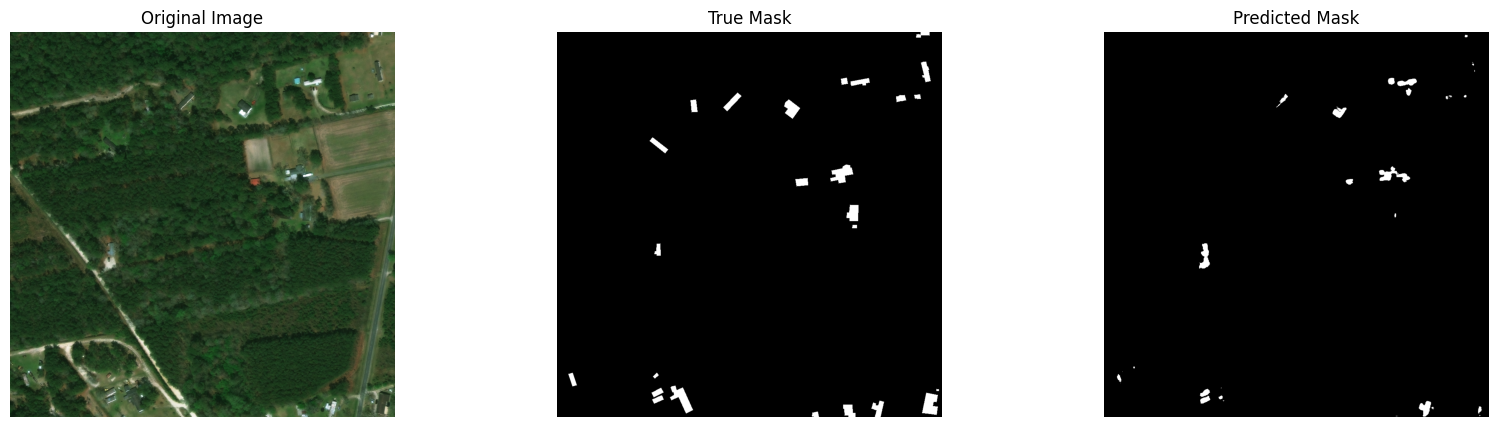

In [15]:
import matplotlib.pyplot as plt

def visualize_predictions(image, true_mask, predicted_mask, threshold=0.5):
    # Assuming the predicted mask is a probability map, we threshold it to create a binary mask
    binary_predicted_mask = (predicted_mask.squeeze() > threshold).astype(np.uint8)

    # Set up the matplotlib figure and axes
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    
    # Original image
    axes[0].imshow(image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # True mask
    # Only display if a true mask is provided (not None)
    if true_mask is not None:
        axes[1].imshow(true_mask.squeeze(), cmap='gray')
        axes[1].set_title('True Mask')
    axes[1].axis('off')

    # Predicted mask
    axes[2].imshow(binary_predicted_mask, cmap='gray')
    axes[2].set_title('Predicted Mask')
    axes[2].axis('off')

    # Show the plots
    plt.show()

# Example usage:
# Replace 'your_image' and 'your_true_mask' with the actual image and true mask arrays
true_mask = tifffile.imread('data\\train\\masks\\hurricane-florence_00000026_pre_disaster_mask.tif')
visualize_predictions(image, true_mask, predicted_mask)
